#  Smoke-Fire Detection Model - Milestone 1

This notebook contains the full work for Milestone 1:  
**Data Collection, Preprocessing, and Exploratory Data Analysis** on the FireSmoke Detection YOLO v9 dataset.


# Preprocessing Pipeline Documentation

## Dataset:
- **Source**: Kaggle FireSmoke Detection YOLO v9 Dataset
- **Structure**:
  - `train/images/`, `train/labels/`
  - `valid/images/`, `valid/labels/`
  - `test/images/`, `test/labels/`
- Each image has a corresponding YOLO `.txt` label file.

## Preprocessing Steps:
- **Resize**: 
  - All images resized to 640x640 pixels using Albumentations.
- **Normalization**: 
  - Applied ImageNet standard normalization with mean = (0.485, 0.456, 0.406) and std = (0.229, 0.224, 0.225).
- **Data Augmentation**:
  - Horizontal Flip (50% probability)
  - Random Brightness and Contrast adjustment
  - Color Jittering
  - Random 90-degree rotation
- **Bounding Box Handling**:
  - YOLO bounding boxes remain correctly aligned after transformations.
- **Splits**:
  - Dataset already pre-divided into `train`, `valid`, and `test` sets.

## Tools Used:
- Python 3
- Albumentations
- OpenCV
- Matplotlib


## 1. Installing and Importing Libraries

In this section, we install necessary libraries and import Python packages for data processing, visualization, and augmentation.


In [11]:
# For interacting with the operating system
import os

# For generating random numbers
import random

# OpenCV library for image processing and computer vision tasks
import cv2

# For retrieving files/pathnames matching a specified pattern 
import glob

# For data manipulation and analysis
import pandas as pd

# For building and training deep learning model
import tensorflow as tf

# For plotting and visualization
import matplotlib.pyplot as plt

# For counting hashable objects
from collections import Counter

# For image augmentation
import albumentations as A

# To convert augmented images into PyTorch tensors
from albumentations.pytorch import ToTensorV2

# For augmenting image data on the fly during training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Dataset Path Definition

We define the dataset path where the FireSmoke Detection YOLO v9 dataset is located inside Kaggle environment.


In [17]:
#define base dataset path
Dataset_Path = '/kaggle/input/firesmoke-detection-yolo-v9/Fire and Smoke Dataset'

Train_Path = os.path.join(Dataset_Path, "train")

Valid_Path = os.path.join(Dataset_Path, "valid")

Test_Path = os.path.join(Dataset_Path, "test")

splits = ['train', 'valid', 'test']

# Data Augmentation

## 3. Preparing Data Generators for Model Training

We define data generators for the training, validation, and testing sets:
- **Training Generator**: applies data augmentation techniques such as rotation, zoom, width/height shifts, and flipping to improve model robustness.
- **Validation and Test Generators**: only rescale images without augmentation to evaluate model performance accurately.


In [13]:
Image_Size = (640, 640)  
Batch_Size = 32

# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Generators
train_generator = train_datagen.flow_from_directory(
    Train_Path,
    target_size=Image_Size,
    batch_size=Batch_Size,
    class_mode='categorical', 
    shuffle=True
)

# Validation/test data (only rescale)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    Valid_Path,
    target_size=Image_Size,
    batch_size=Batch_Size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    Test_Path,
    target_size=Image_Size,
    batch_size=Batch_Size,
    class_mode='categorical',
    shuffle=False
)

Found 35695 images belonging to 2 classes.
Found 4892 images belonging to 2 classes.
Found 2255 images belonging to 2 classes.


## 4. Defining a Function to Visualize Bounding Boxes

We define a helper function `plot_image_with_bboxes(img_path, label_path)` that:
- Reads an image and its corresponding label file.
- Parses bounding box information (YOLO format).
- Draws the bounding boxes on the image.
- Displays the annotated image using Matplotlib.

This step helps visually verify that annotations are accurate before proceeding with model training.


In [14]:
#define a function to plot images with bounding boxes
def plot_image_with_bboxes(img_path, label_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    
    with open(label_path, 'r') as file:
        labels = file.readlines()
    
    for label in labels:
        class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.split())
        x_center *= w
        y_center *= h
        bbox_width *= w
        bbox_height *= h
        
        x1 = int(x_center - bbox_width / 2)
        y1 = int(y_center - bbox_height / 2)
        x2 = int(x_center + bbox_width / 2)
        y2 = int(y_center + bbox_height / 2)
        
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 5. Visualizing Random Samples with Bounding Boxes

We visualize random images from each split (train, validation, test) and overlay their corresponding bounding boxes to inspect annotation quality.


Showing samples from TRAIN set:


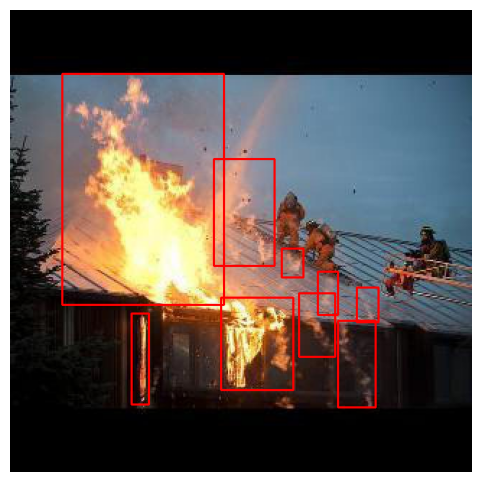

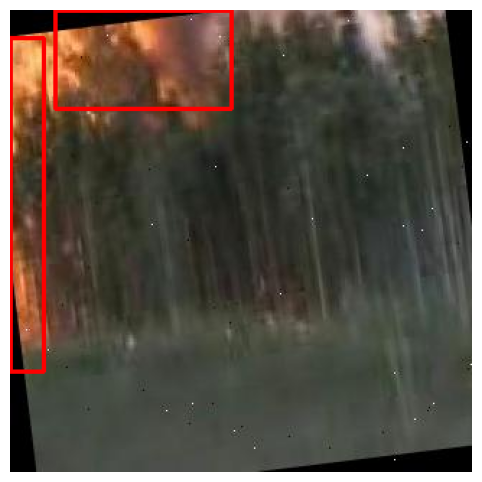

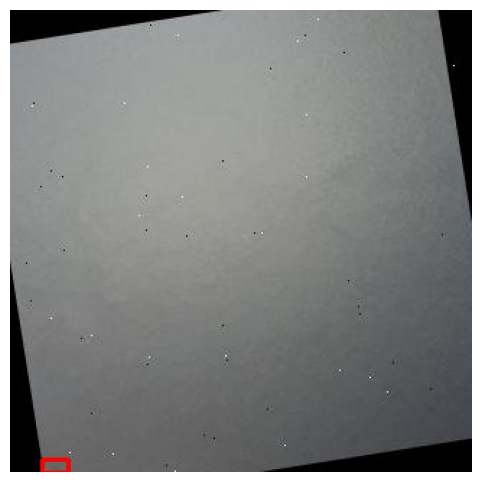

Showing samples from VALID set:


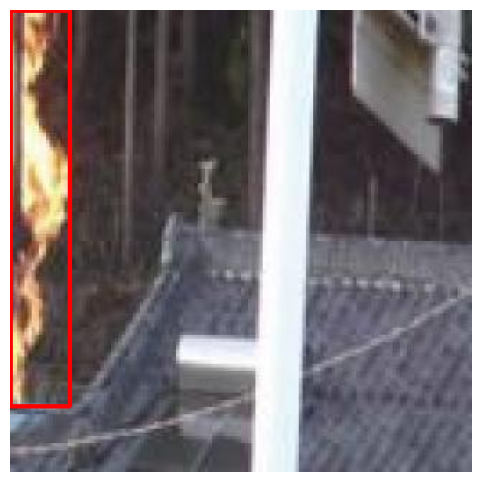

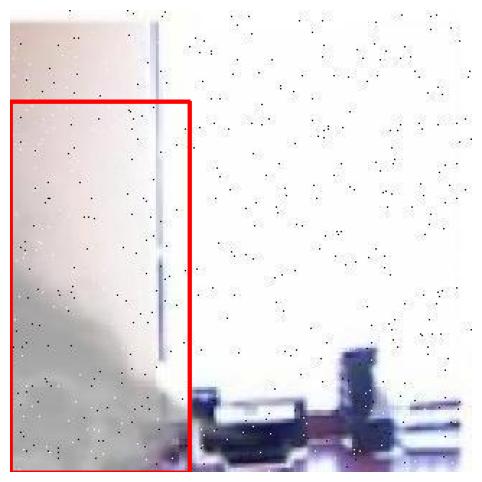

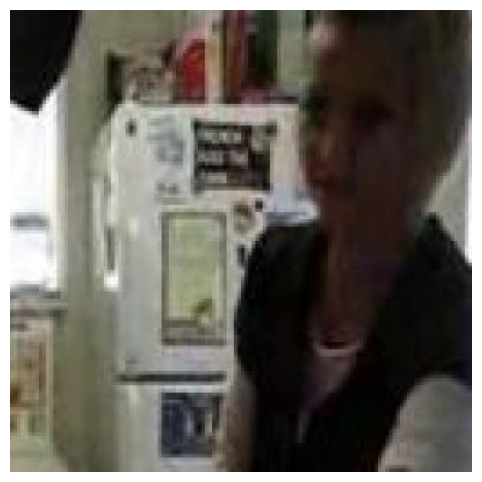

Showing samples from TEST set:


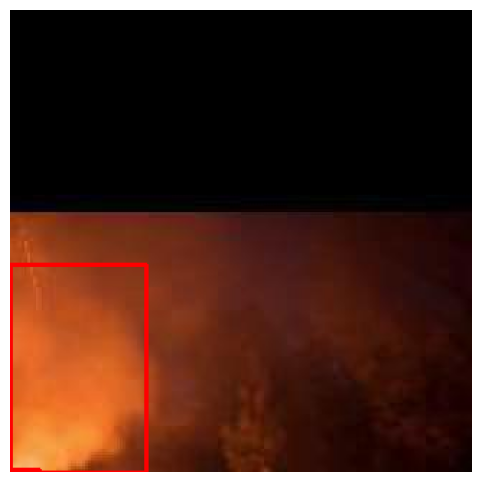

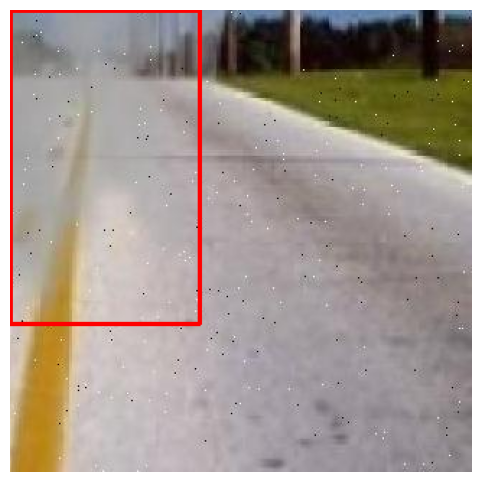

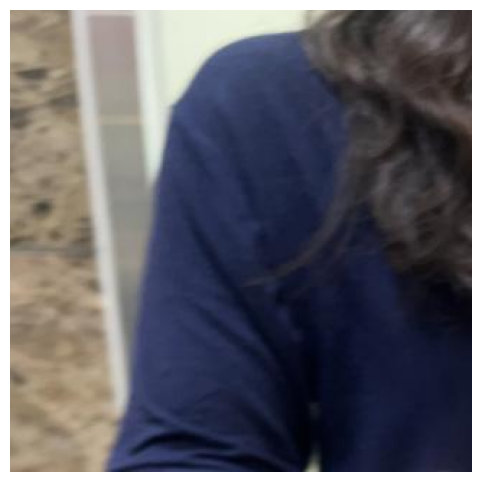

In [18]:
#visualize random images from each split
for split in splits:
    print(f"Showing samples from {split.upper()} set:")
    images_folder = os.path.join(Dataset_Path, split, 'images')
    labels_folder = os.path.join(Dataset_Path, split, 'labels')
    
    sample_images = random.sample(os.listdir(images_folder), 3)

    for img_name in sample_images:
        img_path = os.path.join(images_folder, img_name)
        label_path = os.path.join(labels_folder, img_name.replace('.jpg', '.txt'))
        plot_image_with_bboxes(img_path, label_path)

## 6. Analyzing Class Distribution

We analyze the distribution of classes (e.g., fire, smoke) in the training set by counting the number of instances per class.


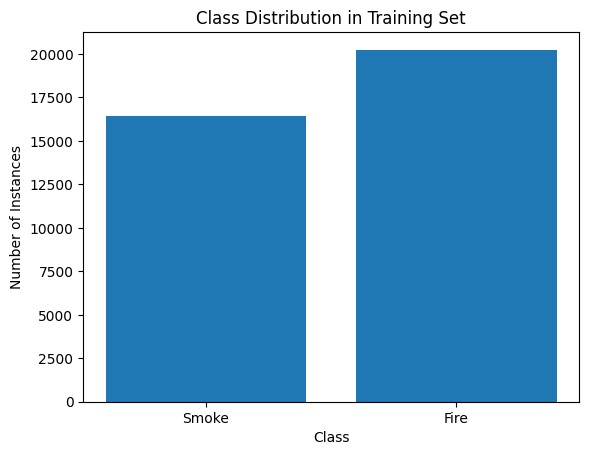

Imbalance Ratio: 1.23


In [19]:
def count_classes(labels_dir):
    counter = Counter()
    for label_file in os.listdir(labels_dir):
        if not label_file.endswith('.txt'):
            continue  # Skip non-text files
            
        filepath = os.path.join(labels_dir, label_file)
        
        try:
            with open(filepath, 'r') as f:
                
                for line in f:
                    
                    line = line.strip()
                    
                    if not line:  # Skip empty lines
                        continue
                    parts = line.split()
                    
                    if len(parts) >= 1:  # At least class_id exists
                        class_id = int(parts[0])
                        counter[class_id] += 1
        except Exception as e:
            print(f"Error processing {filepath}: {str(e)}")
            continue
            
    return counter


# Define paths
train_labels_dir = os.path.join(Dataset_Path, 'train', 'labels')

# Get class counts
train_class_counts = count_classes(train_labels_dir)

# Plotting
if train_class_counts:
    class_names = {0: "Fire", 1: "Smoke"}  # Update with your actual class mapping
    classes = [class_names.get(id, f"Class_{id}") for id in train_class_counts.keys()]
    counts = list(train_class_counts.values())
    
    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Instances')
    plt.title('Class Distribution in Training Set')
    plt.show()
    
    # Calculate imbalance ratio
    if len(train_class_counts) > 1:
        imbalance_ratio = max(counts) / min(counts)
        print(f"Imbalance Ratio: {imbalance_ratio:.2f}")
    else:
        print("Warning: Only one class found in dataset")
else:
    print("No valid label files found or all files were empty")

## 7. Checking for Missing Labels

We verify that every image file has a corresponding label file in all dataset splits to ensure data completeness.


In [20]:
#check for missing labels
def check_missing_labels(images_dir, labels_dir):
    image_files = [os.path.splitext(f)[0] for f in os.listdir(images_dir)]
    label_files = [os.path.splitext(f)[0] for f in os.listdir(labels_dir)]
    
    missing_labels = list(set(image_files) - set(label_files))
    if missing_labels:
        print(f"Missing labels for {len(missing_labels)} images.")
        print(missing_labels)
    else:
        print("All images have corresponding labels.")

for split in splits:
    print(f"\nChecking {split.upper()} set:")
    images_dir = os.path.join(Dataset_Path, split, 'images')
    labels_dir = os.path.join(Dataset_Path, split, 'labels')
    check_missing_labels(images_dir, labels_dir)


Checking TRAIN set:
All images have corresponding labels.

Checking VALID set:
All images have corresponding labels.

Checking TEST set:
All images have corresponding labels.


# Exploratory Data Analysis (EDA) Report

## 1. Dataset Overview:
- Total dataset divided into three parts:
  - Training set
  - Validation set
  - Test set
- Each set contains both images and their corresponding bounding box annotations.

## 2. Visual Sample Exploration:
- Randomly selected images from each set were visualized with their bounding boxes drawn.
- Observations:
  - Images are highly varied in background, lighting, and smoke/fire visibility.
  - Bounding boxes accurately enclose smoke or fire regions.

## 3. Class Distribution:
- Training set class distributions were plotted.
- Observation:
  - Class 0 and Class 1 (e.g., Fire and Smoke) are present.
  - Some class imbalance was observed, but not severely critical.

## 4. Data Quality Check:
- Checked that every image has a corresponding label file.
- No missing labels found across train, valid, and test splits.

## 5. Conclusion:
- Dataset quality is good and ready for deep learning model training.
- Minor class imbalance can be handled during model training with techniques like class weights if necessary.


## 8. Conclusion

The dataset is well-prepared for the next phase of model development.  
We completed:
- Data verification
- Exploratory Data Analysis (EDA)
- Preprocessing pipeline setup

The project is ready to proceed to Milestone 2: **Model Training and Evaluation**.
